### <center>Two-cycle component splitting method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import warnings


warnings.filterwarnings('ignore')

In [2]:
def zero_t_func(x_values, y_values):
    x, y = sp.symbols('x y')
    expr = x**2 + y**2
    func = sp.lambdify((x, y), expr, "numpy")
    X, Y = np.meshgrid(x_values, y_values, indexing='ij')
    return func(X, Y) # x, y


def true_func(t_values, x_values, y_values):
    x, y, t = sp.symbols('x y t')
    expr = t + x**2 + y**2
    func = sp.lambdify((t, x, y), expr, "numpy")
    T, X, Y = np.meshgrid(t_values, x_values, y_values, indexing='ij')
    return func(T, X, Y) # t, x, y


def boundary_x_func(t_values, y_values, value):
    x, y, t = sp.symbols('x y t')
    expr = t + x**2 + y**2
    expr = expr.subs(x, value)
    func = sp.lambdify((t, y), expr, "numpy")
    T, Y = np.meshgrid(t_values, y_values, indexing='ij')
    return func(T, Y) # t, y

def boundary_y_func(t_values, x_values, value):
    x, y, t = sp.symbols('x y t')
    expr = t + x**2 + y**2
    expr = expr.subs(y, value)
    func = sp.lambdify((t, x), expr, "numpy")
    T, X = np.meshgrid(t_values, x_values, indexing='ij')
    return func(T, X) # t, x


def f_func():
    x, y, t = sp.symbols('x y t')
    expr = t + x**2 + y**2
    result = sp.diff(expr, t, 1) - sp.diff(expr, x, 2) - sp.diff(expr, y, 2)
    return int(result) if bool(result.free_symbols) == False else result


def Delta_op(n):
    Delta = np.zeros((n, n))
    for i in range(1, n-1):
        Delta[i, i] = -2
        Delta[i, i - 1] = 1
        Delta[i, i + 1] = 1
    Delta[0, 0] = 1
    Delta[-1, -1] = 1
    return Delta


def tridiagona_matrix_algorithm(A, b):
    n = A.shape[0]
    c = np.zeros(n-1) # subdiagonal elements
    d = np.zeros(n) # main diagonal
    e = np.zeros_like(c) # supradiagonal elements
    
    for i in range(n - 1):
        c[i] = A[i+1, i]
        d[i] = A[i, i]
        e[i] = A[i, i+1]
    d[n-1] = A[n-1, n-1]
    
    alpha = np.zeros(n-1)
    beta = np.zeros_like(alpha)
    
    # Straight direction
    alpha[0] = -e[0] / d[0]
    beta[0] = b[0] / d[0]
    
    for i in range(1, n - 1):
        alpha[i] = -e[i] / (c[i - 1] * alpha[i - 1] + d[i])
        beta[i] = (b[i] - c[i - 1] * beta[i - 1]) / (c[i - 1] * alpha[i - 1] + d[i])
    
    # Reverse direction
    x = np.zeros_like(b)
    x[n - 1] = (b[n - 1] - c[n - 2] * beta[n - 2]) / (c[n - 2] * alpha[n - 2] + d[n - 1])
    
    for i in range(n - 2, -1, -1):
        x[i] = alpha[i] * x[i + 1] + beta[i]

    return x


def two_cycle_splitting_method(u, n_t, t, x, y, tau, l1, l2):
    for n in range(1, n_t-1, 2):
    
        phi_half_minus = np.zeros_like(u[n - 1])
        for j in range(len(y)):
            E = np.eye(len(l1))
            b = (E - tau / 2 * l1) @ u[n - 1, :, j]
            A = E + (tau / 2) * l1
            A[0] = A[-1] = 0
            A[0, 0] = A[-1, -1] = 1
            
            b[0] = boundary_x_func((t[n - 1] + t[n]) / 2, y[j], x[0])
            b[-1] = boundary_x_func((t[n - 1] + t[n]) / 2, y[j], x[-1])
 
            phi_half_minus[j] = tridiagona_matrix_algorithm(A, b)
 
        u[n] = phi_half_minus

 
        phi_n = np.zeros_like(u[n])
        for i in range(len(x)):
            E = np.eye(len(l2))
            b = (E - (tau / 2) * l2) @ u[n, i]
            A = E + (tau / 2) * l2
            A[0] = A[-1] = 0
            A[0, 0] = A[-1, -1] = 1
 
            b[0] = boundary_y_func(t[n], x[i], y[0])
            b[-1] = boundary_y_func(t[n], x[i], y[-1])
 
            phi_n[i] = tridiagona_matrix_algorithm(A, b)
 
        u[n] = phi_n + tau * f_func()
 

        phi_half_plus = np.zeros_like(u[n])
        for i in range(len(x)):
            E = np.eye(len(l2))
            b = (E - (tau / 2) * l2) @ (u[n, i] + tau * f_func())
            A = E + (tau / 2) * l2
            A[0] = A[-1] = 0
            A[0, 0] = A[-1, -1] = 1
 
            b[0] = boundary_y_func((t[n] + t[n + 1]) / 2, x[i], y[0])
            b[-1] = boundary_y_func((t[n] + t[n + 1]) / 2, x[i], y[-1])
 
            phi_half_plus[i] = tridiagona_matrix_algorithm(A, b)
 
        u[n + 1] = phi_half_plus
 

        for j in range(len(y)):
            E = np.eye(len(l1))
            b = (E - (tau / 2) * l1) @ u[n + 1, :, j]
            A = E + (tau / 2) * l1
            A[0] = A[-1] = 0
            A[0, 0] = A[-1, -1] = 1
 
            b[0] = boundary_x_func(t[n + 1], y[j], x[0])
            b[-1] = boundary_x_func(t[n + 1], y[j], x[-1])
 
            u[n + 1, :, j] = tridiagona_matrix_algorithm(A, b)
    
    return u

In [3]:
n_x = n_y = 11
n_t = 1001
left_x, right_x, left_y, right_y, left_t, right_t = 0, 1, 0, 1, 0, 1
x = np.linspace(left_x, right_x, n_x)
y = np.linspace(left_y, right_y, n_y)
t = np.linspace(left_t, right_t, n_t)

 
h_x = np.diff(x)
h_y = np.diff(y)
tau = np.diff(t)

h_x = h_x[0] if np.all(np.isclose(h_x, h_x[0], atol=1e-14)) else h_x
h_y = h_y[0] if np.all(np.isclose(h_y, h_y[0], atol=1e-14)) else h_y
tau = tau[0] if np.all(np.isclose(tau, tau[0], atol=1e-14)) else tau
 

u = np.zeros((n_t, n_x, n_y))
 
u[:, 0, :] = boundary_x_func(t, y, 0)
u[:, -1, :] = boundary_x_func(t, y, 1)
u[:, :, 0] = boundary_y_func(t, x, 0)
u[:, :, -1] = boundary_y_func(t, x, 1)
u[0, :, :] = zero_t_func(x, y)

 
l1 = -Delta_op(n_x) / h_x ** 2
l2 = -Delta_op(n_y) / h_y ** 2

u = two_cycle_splitting_method(u, n_t, t, x, y, tau, l1, l2)

In [4]:
max_error = np.max(np.abs(u - true_func(t, x, y)))
print("Max_error:", max_error)

Max_error: 0.0030000000000001137


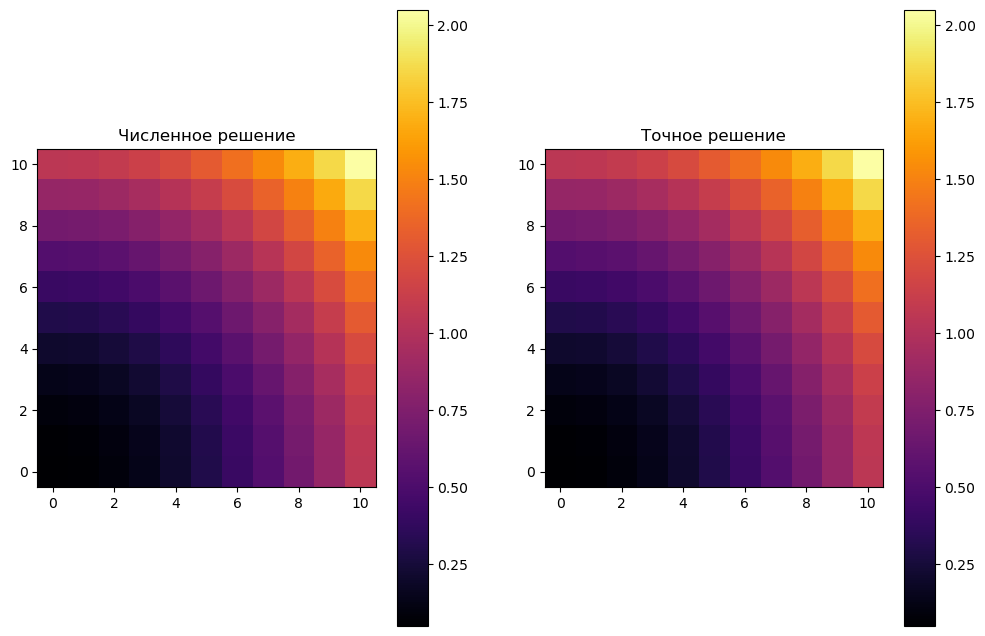

In [5]:
%matplotlib inline

t_fixed = 50
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(u[t_fixed, :, :], cmap='inferno', origin='lower')
plt.title('Численное решение')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(true_func(t, x, y)[t_fixed, :, :], cmap='inferno', origin='lower')
plt.title('Точное решение')
plt.colorbar()

plt.show()